In [1]:
import numpy as np
import open3d as o3d
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter
from scipy import signal
from skimage import measure
#import skfmm

import PointCloudMask as pcm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


unique masks intial: 12
unique black bg mask: 12
unique masks erode: 15
unique mask colors: 15
(1555200, 3)
15


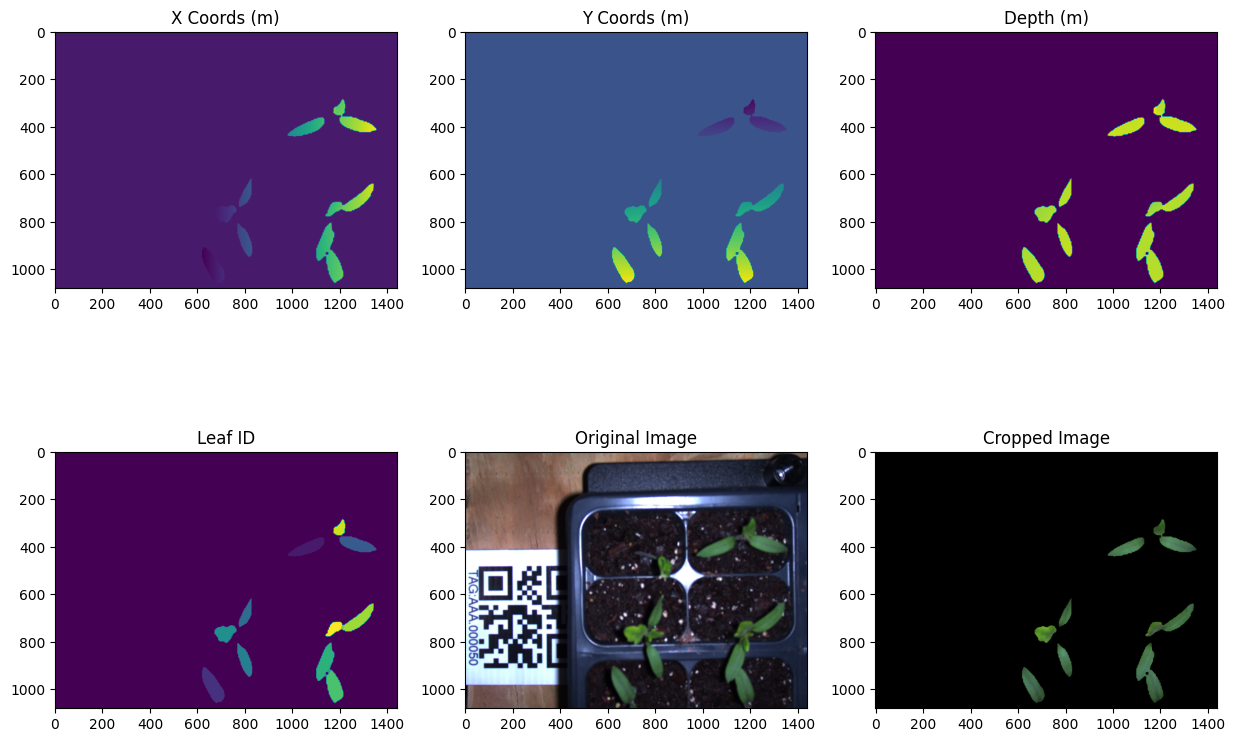

In [2]:
leafs = pcm.apply_depth_mask("Pointclouds/demo_ (1).pcd", 'Images/aggrigated_masks (1).png',
                             "Arrays/depth (1).npy", "Images/left_rect (1).png",  plot=True)

In [3]:
index = np.unique(leafs[:,:,3])
mask = leafs[:,:,3]
coordinates = []
for i, _ in enumerate(index):
        if i == 0:
                continue
        mask_ = mask == index[i]
        mask_ = np.where(mask_, mask_ >= 1, 0)
        labels = measure.label(mask_)
        props = measure.regionprops(labels)
        for prop in props:
                if prop.area <= 200:
                        pixels = prop.coords
                        coordinates.append(pixels)
        #plt.imshow(mask_)
        #plt.show()
for i, coord in enumerate(coordinates):
        coor_ = np.array(coord)
        mask[(coor_[:,0], coor_[:,1])] = 0

leafs[:,:,3] = mask

Test 1: Performing convolution with needle array to erode away leaf edges

In [4]:
depth_image = leafs[:,:,2].astype('float32')
mask_image = leafs[:,:,3].astype('uint8')
kernels = pcm.get_kernels(depth_image, mask_image)
no_leaves = np.unique(mask_image)
graspable_mask = pcm.do_convolution(kernels, mask_image)

average kernel size:  38.0
average kernel size:  39.0
average kernel size:  37.0
average kernel size:  39.0
average kernel size:  38.0
average kernel size:  40.0
average kernel size:  39.0
average kernel size:  39.0
average kernel size:  39.0
average kernel size:  38.0
average kernel size:  41.0
all kernels:  [38.0, 39.0, 37.0, 39.0, 38.0, 40.0, 39.0, 39.0, 39.0, 38.0, 41.0]


In [5]:

binary_grasp_mask = graspable_mask >=1
leafs[:,:,3] = leafs[:,:,3]*binary_grasp_mask
leafs_ = np.reshape(leafs[:,:,0:3], (1555200, 3))
index = np.argwhere(leafs_ == [0,0,0])
inverse_index = np.nonzero(leafs_[:,2])
leafs__ = np.delete(leafs_, index,0)


In [6]:

processed_pcd = o3d.geometry.PointCloud()
processed_pcd.points = o3d.utility.Vector3dVector(leafs__)

In [7]:
pcm.compute_normals(processed_pcd)
sqrt_dist = np.sum((processed_pcd.normals[999])**2, axis=0)
dist = np.sqrt(sqrt_dist)
normal_orientation = np.asarray(processed_pcd.normals)[:,2]
normal_orientation = abs(normal_orientation)
orientation_color = np.zeros((len(normal_orientation), 3))
orientation_color[:,0]=normal_orientation
orientation_color[:,1]=0
orientation_color[:,2]=0
processed_pcd.colors = o3d.utility.Vector3dVector(orientation_color)

Computing Normals!


In [8]:
leaf_flatness = np.zeros((1555200, 1))
j=0
for i in range(len(inverse_index[0])):
    current_index = inverse_index[0][i]
    leaf_flatness[current_index,0] = normal_orientation[j]
    j+=1

In [9]:
leaf_flatness = np.reshape(leaf_flatness, (1080,1440,1))
leafs = np.concatenate((leafs, leaf_flatness), axis=2)

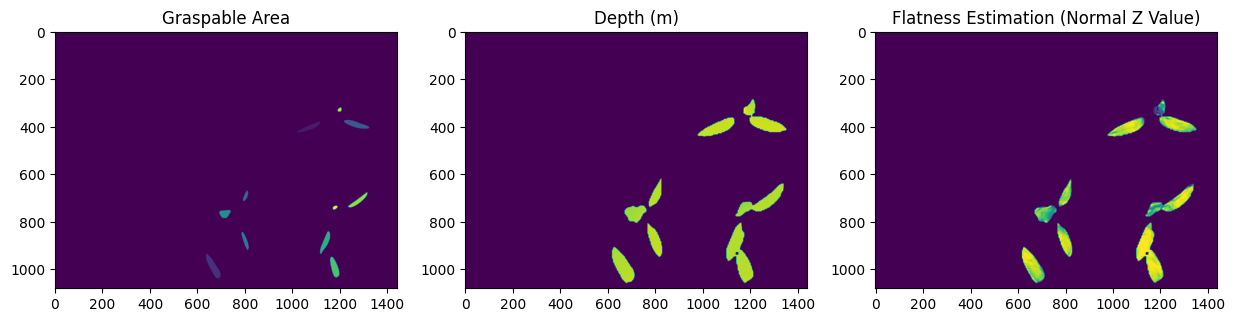

In [10]:
fig, ax = plt.subplot_mosaic([
            ['mask', 'z', 'flatness']
        ], figsize=(15,10))

ax['z'].imshow(leafs[:, :, 2])
ax['z'].set_title("Depth (m)")
ax['mask'].imshow(leafs[:, :, 3])
ax['mask'].set_title("Graspable Area")
ax['flatness'].imshow(leafs[:,:,4])
ax['flatness'].set_title("Flatness Estimation (Normal Z Value)")
plt.show()

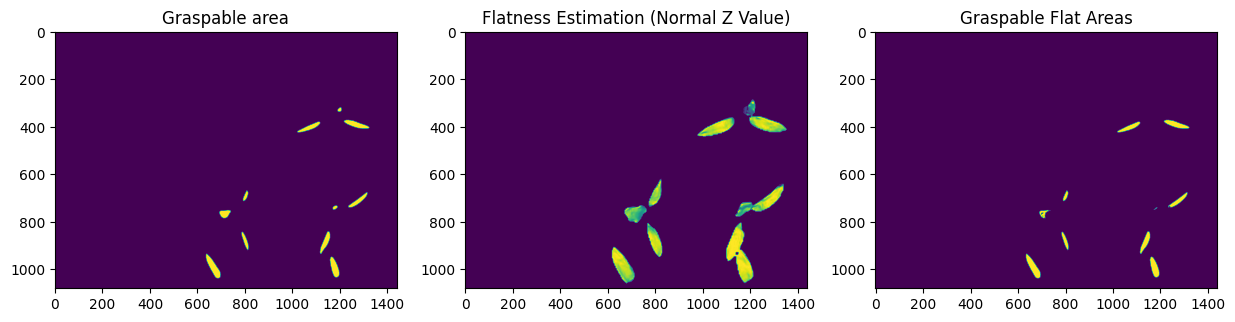

In [11]:
alpha = 0.5
graspable_area = binary_grasp_mask
smooth_section = leafs[:,:,4]
leaf_selection_a = alpha*smooth_section+(1-alpha)*graspable_area


leaf_selection_ab = np.where(leaf_selection_a, leaf_selection_a > np.amax(leaf_selection_a)*0.85,
                                      0)  # remove blurry parts


fig, ax = plt.subplot_mosaic([
            ['grasp', 'flatness', 'combined']
        ], figsize=(15,10))

ax['grasp'].imshow(graspable_area)
ax['grasp'].set_title("Graspable area")
ax['combined'].imshow(leaf_selection_ab)
ax['combined'].set_title("Graspable Flat Areas")
ax['flatness'].imshow(leafs[:,:,4])
ax['flatness'].set_title("Flatness Estimation (Normal Z Value)")
plt.show()


1385.5
2467.0
1806.5
437.0
830.0
1.0
1532.5
1923.5
1276.0
14.5


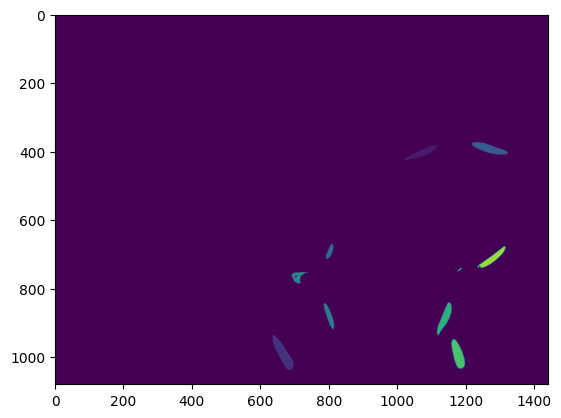

In [12]:

centroids = pcm.get_centroids((leaf_selection_ab*leafs[:,:,3]).astype('uint8'))
plt.imshow(leaf_selection_ab*leafs[:,:,3])

In [13]:
print(len(centroids))
print(len(np.unique(leafs[:,:,3])))

10
12


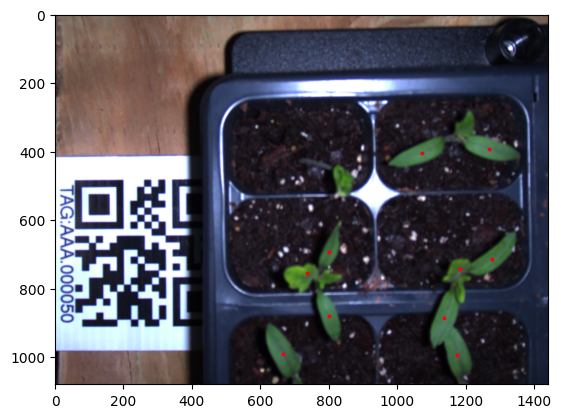

In [23]:

#plt.scatter(centroids[:][0], centroids[:][1])
for i, _ in enumerate(centroids):
    plt.scatter(centroids[i][0], centroids[i][1],s=3,c='r')

left_image = Image.open("Images/left_rect (1).png")
left_array = np.asarray(left_image)[:, :, 0:3]
plt.imshow(left_array)
plt.show()